In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'default-of-credit-card-clients-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F306%2F666%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T115223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D60818bf2d10915153173140b1d417d9bebf90e511905f5f997e7ea7c5bc87a05a0fe56a9c0601a8ae3129b0726f4c25f9fb88214f225c384345bdbe08ca64b4670166ebd260b629c70c8c7559f592efa3f5332b10a0ba07c1448d843356715b8b6df0f9a3be53a8b76092edb705863e135763c2453b82078b63b3f457afb77510187e678e572982391c4cf220cf5bad19e815d390cf120fb69f152933c70bb3a73b1ddb6b50e14839694976c6c33e0f61cd2b5762155f13f9a9cb8503245ce63316daf0a1122fb844fa8d9637eb039b89dad74b4221524937e298f72a5c403e2ca42554da3e072f1af15b4d1e1751af0d37e4911a7290b02715f3f1f0d329005,german-credit:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F531%2F1056%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T115223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D05f676cd8e55443d4af9924a0c831daf462a5d01c463a988ed8cb038439a441be4c5f5167c3f211ac98d62daad891ea6db8bc8581c3842a699b7ef7cda16f060db456bdc88941dfc114ffce577f850adeaeada3483007e32edde87d8becdbe0de68869929bb8d08af93649c30cfc2aa79c92deaaed4690ebf1c6878c3bb095dcf2463490e9fb8cdbce01db1a96477628d38cb201543b8c460b4730f0a5aa3156ac5b326a7e65af33275def20f1ac005c25236be47a7b0a57cc80c71a241691d3b2b4d24f63dce7a7c8a5045e82afb279dd510246a26d0accd8180a862dbef85b782253a23ba7496150350316769670e3eabeae87e15bf910730e4171751ebd34,creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T115223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D69cb30e253329b2aa2cd63ffc8f64588fd2091a20e6ca85dcdc34281c30b6724243aad9a8417661656070b8631f645c4d65d692d34ea74079e70032d587361ba0bb6a5a5657f46a3c62b989832354279d80e51964ad749daaf2920ec5dceba0b82e17a77584aeefed7118aba975cc77f81baa07bddb679b3e4ec881e13a094c4926eb1c927999a7fb1180c902d93bb203f17519cd77c3bb527270bee6a4ba84398dbc0edadb37f377b85a98f294d42302f8b7641b40cd5af5ac1ed3bdc1fb1cf1fd19e46cd564eeb141b634049b75de32d951a87bb82404a3c2862209388ea08192b3c3f38a0b39072319379e9cc181ed3f274fdc23ed0b6ddb3a84ba228d0bf,credit-card:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F263888%2F552038%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T115223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5cc973e9ab99df1bbe80ea40e4f2de1c551e2b0434dfb4ac4fc47c3aa5eec0c724c7ea333a39347f95b2e7bdd96272eca8c1af61d3acbae624eec7f863de96d21e8718e629c6cd677325b588a02eba7c15eea27b325a2377d1dd7a6f6d18f3c699bc2eb5b32b98e89b6f525add99c9badeb0b1f54b142d2a941b70f8794bf888d7d8ca390efcab268d183c109e8706cb175722dd3cc5b1310935276776449da109e09a165af1f5f9c51df8dbac04765c14d0fb29b6ba3cde790d241cd77b84cd042420caa5471345a7dc7610756424e1310ba72807ab21101b11e6355abc0325ae6f298e2cb803e39d6dd6c8d08a5449f4718166294dd1ea298a24f896e6f098,fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817870%2F1399887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T115223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D12420c31d0b3a6c40b2478c7342056e825bbfcce551eb039f3732fb39fd1030381d80c139cceea33e032ab13e6742eeff355446b9ce3e73054735cb2acf22a3fcb0074375c0ae57095bfbc3ed1c3291a5d9f9c41e5ce99edfb71769c0e7bca901d9074e48bb270fe5cb65a569aa451bfbe3490fc0541b0140c28fe36b144e50b93613c6d0c31d5396bda8a71258efab2315d6116e5121ed6f11a229ff2f795e27a5359dca996f93c2e37466a377f54e99e4c58dad6262b13bcf1853d109d690546eab1a973e7a1f16938b2ad07b79c2bd609259fe00a08c78ba5aa33f3fe238095c430ca999d4210e56ca679e124f6802b52f500f7572badc517c17bd4baa4ef,credit-card-customers:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F982921%2F1660340%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T115223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D69cc48a17bcdefc3c163c8f3fc45db76d9d7d6e9184aaaec0350947561a1a18d8f7fcfc7e14387c68a1b19d51073c9844410410e133c1c445ded4b8002bf8ef90ddf1d27eaf8842dea67f900f113f16a3665ed03cc093bf4e3c873e6286e9d97090c08af4aeaaccd05d2a78da1587aa3c49df8579c2ca037fb924e209894d9b069053d171adc8f6de7d880d5b19c5e7a02069fd9e7e914f163032877b94ddd502e9ab32042cd37afd7dae20b5f9b079435f89edc735f7558c556db27f0ac88be87321b3dfff4f9ee290228e813aeaad81ea27e61fa49d8b0774b0647a504066bfee2bd1c54a809a33710c697ddbf2d5fe4d76cbe8543cc067163481944b3df36,credit-card-customers-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2590623%2F4422779%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T115223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0d510ee0571f57d8c77f3c21b0077c27872c4b0ee8376076af7b84c41de245fa1b71bd355761111e59e28fb994defa158469a7646a93cc15bfdef5871dbd6242b3c37c02d4d6b8549e996dfc5e5d95470dc3b34b46d14fa31be07950e2d6ebd8187da3d7885a7d38a6c20eca137c4845d30db3c0b41e4b66648fef2f90833d921e0b34169385028e56f1cd8b621102073bd4137b0d03618151e39cd1a7ff4fc6cecffbb9345ed5770ef89aa0bfe79a0fbfa280aff831cc78b3f67de959c4798765c31b4eac783c8c76d200f72070e4e9e26b5e321a5aee0dbecdb7b9d0188d58e412e62d7aec93af9edcc3b7a0bea1b381d9898184ec64706009d09b78fb570e,credit-card-spendings:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4541632%2F8050363%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240710%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240710T115224Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D18b2b9c863b70fbf2a4dde43d6c3a6def4ce2dafe0734283597ee296f5e6eecefe5551af23c43da6babc0f2493fa0f2d3262d243c1b5ddff600aefa85b2a66b3a51d2eca8684d68bedcb8045a7e0dc7429d3b82be66440c19d12e4606bde2d02293721fad80b8d760b765c98c40cbf246a757d2d218b441d688da2a74ddde661b562f8ae49abc2c86418546e9e70a9bca7b6193dc7d2ab14ce65ba703b575cfc9852dbe7e39530535f6dbb49e1ed4922b9698c31890300756203bbb26d8e13308347613cfc53a32283a429092bfceecbf759c8074976aecbdacf8056d498d36c68a111613dfcff696a597e688341b045b2190a779f74cb2966e409ca8677697d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1025318 bytes downloaded
Downloaded and uncompressed: default-of-credit-card-clients-dataset
[==================================================] 11160 bytes downloaded
Downloaded and uncompressed: german-credit
[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: creditcardfraud
[==================================================] 117814223 bytes downloaded
Downloaded and uncompressed: credit-card
[==================================================] 211766662 bytes downloaded
Downloaded and uncompressed: fraud-detection
[==================================================] 387771 bytes downloaded
Downloaded and uncompressed: credit-card-customers
[==================================================] 387771 bytes downloaded
Downloaded and uncompressed: credit-card-customers-prediction
[==================================================] 326253 bytes downloaded
Downloaded and uncomp

In [ ]:
import pandas as pd
data =pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


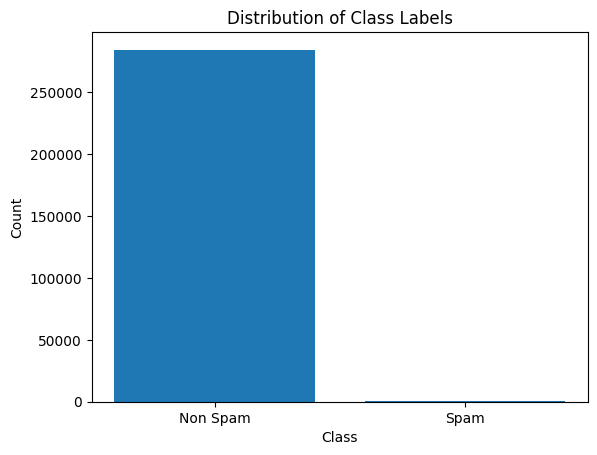

In [ ]:

import matplotlib.pyplot as plt
class_counts = data['Class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non Spam', 'Spam'])  # Label 0 as Non Spam and 1 as Spam
plt.title('Distribution of Class Labels')
plt.show()


In [ ]:
pd.options.display.max_columns = None

In [ ]:
data.shape

(284807, 31)

In [ ]:
print("Number of columns: {}".format(data.shape[1]))
print("Number of rows: {}".format(data.shape[0]))

Number of columns: 31
Number of rows: 284807


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data['Amount'] = sc.fit_transform(pd.DataFrame(data['Amount']))

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [ ]:
data = data.drop(['Time'], axis =1)

In [ ]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [ ]:
data.duplicated().any()

True

In [ ]:
data = data.drop_duplicates()

In [ ]:
data.shape

(275663, 30)

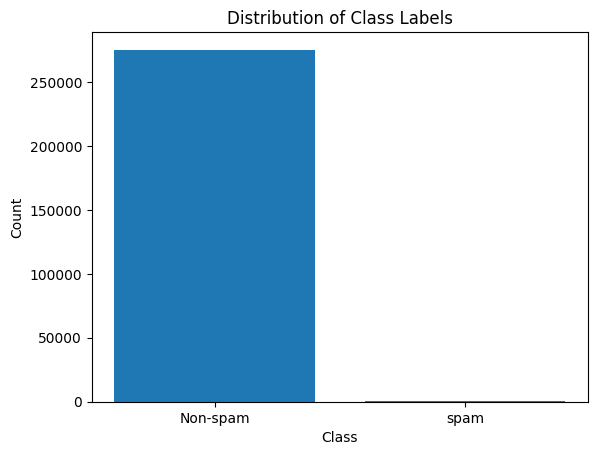

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
class_counts = data['Class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-spam', 'spam'])
plt.title('Distribution of Class Labels')
plt.show()


In [ ]:
data['Class'].value_counts()

Class
0    275190
1       473
Name: count, dtype: int64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
X = data.drop('Class', axis = 1)
y=data['Class']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
import numpy as np

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

classifier = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "K-Nearest Neighbors Classifier": KNeighborsClassifier(),
}

for name, clf in classifier.items():
    print(f"\n=========={name}===========")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n Accuracy: {accuracy}")
    print(f" Precision: {precision}")
    print(f" Recall: {recall}")
    print(f" F1 Score: {f1}")

    # Confusion Matrix
    print("\n Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Classification Report
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))



==========Logistic Regression===========

 Accuracy: 0.9992200678359603
 Precision: 0.8870967741935484
 Recall: 0.6043956043956044
 F1 Score: 0.718954248366013

 Confusion Matrix:
[[55035     7]
 [   36    55]]

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55042
           1       0.89      0.60      0.72        91

    accuracy                           1.00     55133
   macro avg       0.94      0.80      0.86     55133
weighted avg       1.00      1.00      1.00     55133


==========Decision Tree Classifier===========

 Accuracy: 0.9990024123483213
 Precision: 0.6836734693877551
 Recall: 0.7362637362637363
 F1 Score: 0.7089947089947091

 Confusion Matrix:
[[55011    31]
 [   24    67]]

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55042
           1       0.68      0.74      0.71        91

    accuracy                 

In [ ]:
# Undersampling

In [ ]:
normal = data[data['Class']==0]
fraud = data[data['Class']==1]

In [ ]:
normal.shape

(275190, 30)

In [ ]:
fraud.shape

(473, 30)

In [ ]:
normal_sample = normal.sample(n=473)

In [ ]:
normal_sample.shape

(473, 30)

In [ ]:
new_data = pd.concat([normal_sample,fraud], ignore_index=True)

In [ ]:
new_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.519171,0.913665,0.672266,-0.594857,-1.039920,-0.350115,-0.588713,1.150768,0.310064,-0.539776,0.045563,0.206045,-1.437307,0.684658,-0.659932,0.730028,-0.363656,0.923978,-0.186502,-0.113534,0.358668,0.962452,-0.131280,0.102982,-0.340711,0.586487,0.236700,0.112490,-0.233327,0
1,-1.043354,0.771407,0.997782,-0.753236,1.158731,-0.339265,0.457603,0.138741,-0.434527,-0.443759,0.299512,0.071776,-0.160223,-0.288427,-0.086084,1.170872,-0.912144,0.694394,-0.013332,-0.010085,-0.283169,-0.844086,-0.294887,-0.891056,-0.011217,0.004909,0.201888,0.132366,-0.345313,0
2,-1.213774,1.284269,-0.507737,-1.241235,2.444809,3.234164,0.089280,1.107915,-0.953438,-0.418366,-0.365070,-0.230096,-0.094226,0.679210,0.823963,0.276814,-0.571038,0.165415,0.521014,-0.051438,0.034682,-0.360617,-0.304974,1.032802,0.630030,0.379979,-0.545366,-0.017468,-0.346952,0
3,1.041338,-0.207403,0.116612,-0.484607,-0.638518,-0.891700,-0.078686,-0.128538,1.321151,-1.650479,0.653397,1.358734,1.009545,-1.348158,1.280127,-0.747300,1.210293,-0.149304,-0.043101,0.101946,0.042274,0.299518,-0.135550,0.359360,0.573132,-0.628248,0.096632,0.068945,-0.024787,0
4,-1.371531,-2.714639,0.302756,-0.694985,-2.232365,-0.660954,1.566590,-0.449098,-2.643258,0.720957,-0.365360,-0.841793,0.679010,-0.322684,-0.353480,-1.407462,1.227650,0.006129,0.466831,1.326936,0.418419,0.441540,1.641395,0.872196,-0.364062,-0.183816,-0.022705,0.256937,2.201748,0


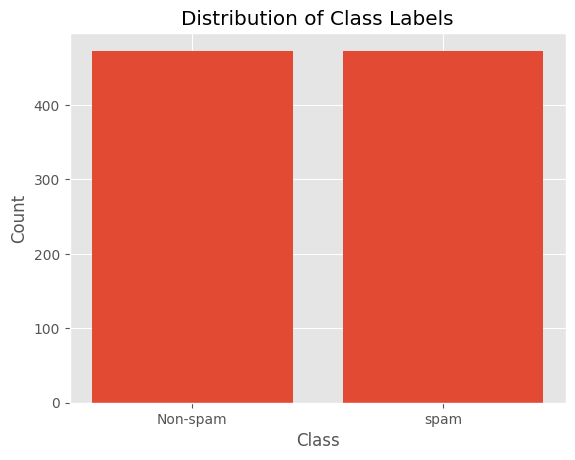

In [ ]:

import matplotlib.pyplot as plt
class_counts = new_data['Class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-spam', 'spam'])
plt.title('Distribution of Class Labels')
plt.show()


In [ ]:
new_data['Class'].value_counts()

Class
0    473
1    473
Name: count, dtype: int64

In [ ]:
X = new_data.drop('Class', axis = 1)
y= new_data['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
classifier = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "K-Nearest Neighbors Classifier": KNeighborsClassifier(),
}

for name, clf in classifier.items():
    print(f"\n=========={name}===========")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n Accuaracy: {accuracy_score(y_test, y_pred)}")
    print(f"\n Precision: {precision_score(y_test, y_pred)}")
    print(f"\n Recall: {recall_score(y_test, y_pred)}")
    print(f"\n F1 Score: {f1_score(y_test, y_pred)}")


==========Logistic Regression===========

 Accuaracy: 0.9368421052631579

 Precision: 0.96875

 Recall: 0.9117647058823529

 F1 Score: 0.9393939393939394

==========Decision Tree Classifier===========

 Accuaracy: 0.9105263157894737

 Precision: 0.9207920792079208

 Recall: 0.9117647058823529

 F1 Score: 0.9162561576354681

==========Random Forest Classifier===========

 Accuaracy: 0.9315789473684211

 Precision: 0.968421052631579

 Recall: 0.9019607843137255

 F1 Score: 0.934010152284264

==========K-Nearest Neighbors Classifier===========

 Accuaracy: 0.9263157894736842

 Precision: 0.9583333333333334

 Recall: 0.9019607843137255

 F1 Score: 0.9292929292929293


In [ ]:
# OVERSAMPLING

In [ ]:
X = data.drop('Class', axis = 1)
y= data['Class']

In [ ]:
X.shape

(275663, 29)

In [ ]:
y.shape

(275663,)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_res, y_res = SMOTE().fit_resample(X,y)

In [ ]:
y_res.value_counts()

Class
0    275190
1    275190
Name: count, dtype: int64

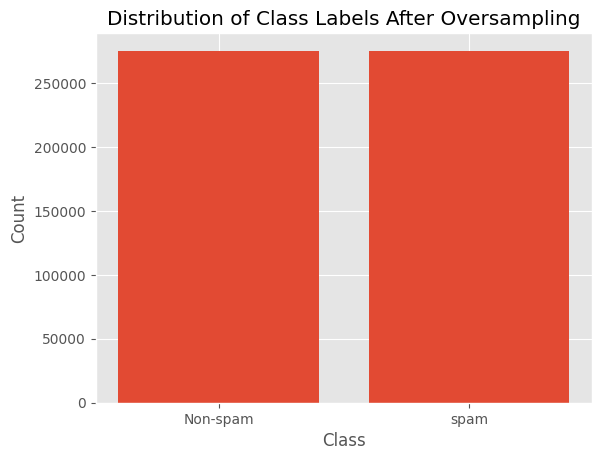

In [ ]:

import matplotlib.pyplot as plt
class_counts = y_res.value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-spam', 'spam'])
plt.title('Distribution of Class Labels After Oversampling')
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

In [ ]:
classifier = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "K-Nearest Neighbors Classifier": KNeighborsClassifier(),
}

for name, clf in classifier.items():
    print(f"\n=========={name}===========")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n Accuaracy: {accuracy_score(y_test, y_pred)}")
    print(f"\n Precision: {precision_score(y_test, y_pred)}")
    print(f"\n Recall: {recall_score(y_test, y_pred)}")
    print(f"\n F1 Score: {f1_score(y_test, y_pred)}")


==========Logistic Regression===========

 Accuaracy: 0.9444293033903848

 Precision: 0.9731513743708866

 Recall: 0.9140046906532371

 F1 Score: 0.9426511536334062

==========Decision Tree Classifier===========

 Accuaracy: 0.9981558196155383

 Precision: 0.9972776769509982

 Recall: 0.9990364161954802

 F1 Score: 0.9981562718545361

==========Random Forest Classifier===========

 Accuaracy: 0.999918238308078

 Precision: 0.9998363993310551

 Recall: 1.0

 F1 Score: 0.9999181929736854

==========K-Nearest Neighbors Classifier===========

 Accuaracy: 0.999046113594244

 Precision: 0.998094650504464

 Recall: 1.0

 F1 Score: 0.9990464167975951


In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_res, y_res)

DecisionTreeClassifier()

In [ ]:
import joblib

In [ ]:
joblib.dump(dtc, "credit_card_model.pkl")

['credit_card_model.pkl']

In [ ]:
model = joblib.load("credit_card_model.pkl")

In [ ]:
pred = model.predict([[-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [ ]:
pred[0]

0

In [ ]:
if pred[0] == 0:
    print("Normal Transcation")
else:
    print("Fraud Transcation")

Normal Transcation
